# Running pcarpet
Here we will demonstrate how to run the pcarpet pipeline data on some example preprocessed fMRI data.

## Initializing pcarpet
`pcarpet` needs 3 paths to be specified:

1. **fMRI file**: a 4d nifti file containing the preprocessed fMRI data
2. **Mask file**: a 3d nifti file, containing a binary mask that defines a single region-of-interest (e.g. cortex)
3. **Output folder**: for storing the outputs generated by pcarpet
   
The fMRI and Mask files need to be in the same space, with identical x-y-z dimensions. For example, they can both be in the native anatomical space of the subject, or in a template space to which the data have been resampled.

In [14]:
import os
import pcarpet

In [4]:
# Folder containing example data
example_folder = '/home/niko/MRI/pcarpet_example/macaque'

# 1. Path to preprocessed fMRI file
func = os.path.join(example_folder, 'func_preproc.nii.gz')
# 2. Path to a cortical mask
cortex_mask = os.path.join(example_folder, 'cortex_mask.nii.gz')
# 3. Path to a folder for storing the outputs
output_folder = os.path.join(example_folder, 'outputs')

To initialize pcarpet, we first create `Dataset` object, using the three paths from above

In [5]:
MyData = pcarpet.Dataset(func, cortex_mask, output_folder)


Initialized Dataset object:
	fMRI file: /home/niko/MRI/pcarpet_example/macaque/func_preproc.nii.gz
	Mask file: /home/niko/MRI/pcarpet_example/macaque/cortex_mask.nii.gz
	Output directory: /home/niko/MRI/pcarpet_example/macaque/outputs


Once the `Dataset` object is created, we have two ways of running the `pcarpet` pipeline on it:

1. Running the entire pipeline at once
2. Running the pipeline step-by-step
   
Below, we will first demonstrate the convenient first option. We will then go through the step-by-step option, which may be useful for debugging and for understanding the vairous inputs and outputs of the pipeline.

## Option 1: Running the entire pcarpet pipeline at once
We can directly call the `run_pcarpet` method of the `Dataset` object, which will execute the pipeline with default options.

Reading data...
	fMRI data read: dimensions (80, 33, 80, 600)
	Mask read: dimensions (80, 33, 80)
fMRI data reshaped to voxels x time (211200, 600).
21589 voxels retained after masking.
Carpet matrix created with shape (21589, 600).
Carpet normalized to zero-mean unit-variance.
Carpet reordered.
PCA fit to carpet and results saved.
First 5 PCs correlated with carpet.
Out of these, 3 sign-flipped.
First 5 PCs correlated with fMRI data.
TR of 2.000 seconds read from fMRI header
Visual report generated and saved as fPCs_carpet_corr_report.


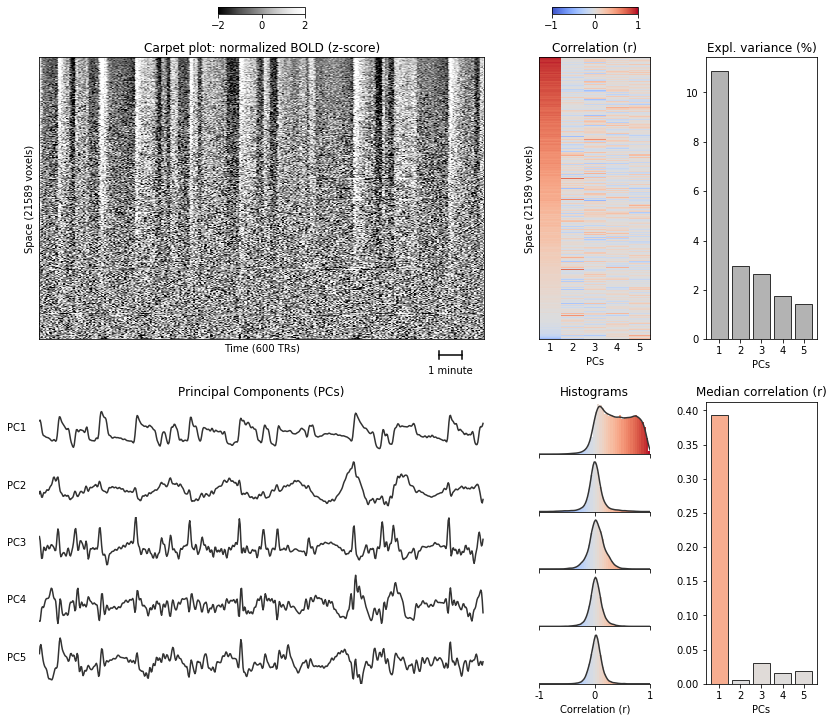

In [6]:
MyData.run_pcarpet()

We can see what the default options were, since they are stored in a dictionary called `used_options`.

In [7]:
ops = MyData.used_options
for key, val in ops.items():
    print(f'{key}: {val}')

tSNR_thresh: 15.0
reorder_carpet: True
save_carpet: False
save_pca_scores: False
ncomp: 5
flip_sign: True
TR: auto


Any of the above default options can be overriden by explicitly passing them as arguments to the `run_pcarpet` call. For example: 

```python
MyData.run_pcarpet(tSNR_thesh=10, reorder_carpet=False)
```

The meaning of each of these option will become clear in the step-by-step guide that follows.

## Option 2: Running pcarpet step-by-step
### Step 1: Importing the data
The first function, `import_data`, uses the `nibabel` package to import the fMRI data and the Mask into python as numpy arrays, and stores them as object attributes `data` and `mask`, respectiveyl. It also stores other attributes, like the x-y-z-t dimensions of fMRI data, the nifti header and the affine matrix.

In [8]:
MyData.import_data()

Reading data...
	fMRI data read: dimensions (80, 33, 80, 600)
	Mask read: dimensions (80, 33, 80)


### Step 2: Getting the carpet
The second function, `get_carpet`, generates a 'carpet' from the fMRI data and the mask. A carpet is a 2d matrix, shaped voxels x time, which contains the normalized (z-score) BOLD-fMRI signal from within the mask.

The fMRI data is first reshaped to 2d. Voxels that are outside the mask as well as voxels below a specified temporal signal-to-noise ratio threshold `tSNR_thresh` (default = 15) are discarded. The retained voxels are tranformed into 2d and normalized through z-scoring (subtract mean and divide by standard deviation along the time dimension).

By default, the rows of the carpet matrix (voxels) are ordered according to their (decreasing) correlation with the global (mean across voxels) signal. The reordering helps to highlight widespread signal fluctuations. It can be turned off by setting the `reorder_carpet` argument to `False`.

The carpet matrix is stored as a `carpet` attribute of the `Dataset` object. Optionally, it can be written to the output folder as a `carpet.npy` file (can be large), by setting the `save_carpet` argument to `True`.

In [9]:
MyData.get_carpet(tSNR_thresh=15.0,
                  reorder_carpet=True, save_carpet=False)

fMRI data reshaped to voxels x time (211200, 600).
21589 voxels retained after masking.
Carpet matrix created with shape (21589, 600).
Carpet normalized to zero-mean unit-variance.
Carpet reordered.


### Step 3: Fit PCA to carpet
The third function, `fit_pca2carpet`, fits PCA to the `carpet` matrix and saves the principal componens (PCs), the explained variance ratios, and optionally the PCA scores (PCA-tranformed carpet). 

The PCs are stored as a `pca_comps` attribute of the `Dataset` object and are also written to the output folder as a `PCs.npy` file. 

The explained variance ratios per PC are stored as a `expl_var` attribute of the `Dataset` object and are also written to the output folder as a `PCA_expl_var.npy` file.

If the `save_pca_scores` option is set to `True`, the PCA-transformed data will be written to the output folder as a `PCA_scores.npy` file (will be large).

In [10]:
MyData.fit_pca2carpet(save_pca_scores=False)

PCA fit to carpet and results saved.


### Step 4: Correlate PCs with carpet
The fourth function, `correlate_with_carpet`, Correlates the first `ncomp` (defaults to 5) principal components (first PCs =  fPCs) with all carpet voxel time-series. The fPCs are written to the output folder as `fPCs.csv`. The correlation matrix is written to the output folder as `fPCs_carpet_corr.npy`.

If the `flip_sign` option is `True` (enabled by default), an fPC (and its correlation values) will be sign-flipped when the median of its original correlation with carpet voxels is negative. This enforces the sign of the fPC to match the sign of the BOLD signal activity for most voxels. The sign-flipped fPCs are only used for downstream analysis and visualization. If any flips occurr, new versions of the two above output files are written: `fPCs_flipped.csv` and `fPCs_carpet_corr_flipped.npy`.

A report table of the above analyis is written to the output folder as `fPCs_carpet_corr_report.csv`. For each fPC,the table reports the explained variance ratio, the original median value of the correlation across carpet voxels, and whether sign-flipping was done for downstream analysis.

In [11]:
MyData.correlate_with_carpet(ncomp=5, flip_sign=True)

First 5 PCs correlated with carpet.
Out of these, 3 sign-flipped.


### Step 5: Correlate PCs with fMRI
The fifth function, `correlate_with_fmri`, correlates the retained (and possibly sign-flipped)
first `ncomp` PCs (fPCs) with the original 4d fMRI dataset. The resulting Pearson's correlation maps are written to the output folder as a 4d NIFTI file (3d space + `ncomp`) named `fPCs_fMRI_corr.nii.gz`. This file contains `ncomp` 3d correation maps, which represent the spatial distribution of each fPC across the brain.

In [12]:
MyData.correlate_with_fmri()

First 5 PCs correlated with fMRI data.


### Step 6: Visualize results
The sixth and final function, `plot_report`, generates a visual report of the results, including the carpet plot, the first `ncomp` PCs (fPCs), their correlation with the carpet, and their explained variance ratios. The plot image, named `fPCs_carpet_corr_report` is written to the output folder in both '.png' (raster) and '.svg' (vector) formats.

To correctly display the time-scale, the function attempts to read the repetition time `TR` from the nifti header (`TR`='auto'). This can be overriden by explicitly passing a `TR` value (in seconds) as an argument

TR of 2.000 seconds read from fMRI header
Visual report generated and saved as fPCs_carpet_corr_report.


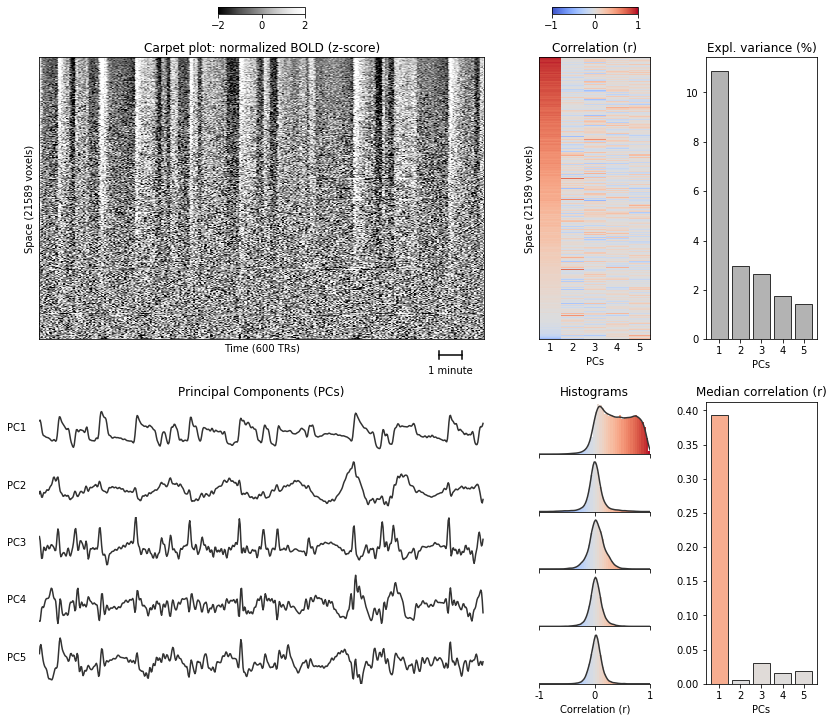

In [13]:
MyData.plot_report(TR='auto')